#### Exercise 5 Solution

In [4]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.dataset import random_split,TensorDataset
import torchvision.transforms as transforms
from torchvision.models import vgg16,VGG16_Weights
from torchsummary import summary
import os
import pandas as pd
from PIL import Image
from skimage import io,transform,color

from PIL import Image

torch.manual_seed(1)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
# Image paths and labels

train = './Mnist_Image_Data/Mnist_Image_Data/Images/train/'
test = './Mnist_Image_Data/Mnist_Image_Data/Images/test/'

train_label = pd.read_csv('./Mnist_Image_Data/Mnist_Image_Data/train.csv')
test_label = pd.read_csv('./Mnist_Image_Data/Mnist_Image_Data/test.csv')

In [7]:
# Setup pretrained VGG16 model

weights = VGG16_Weights.DEFAULT
preprocess = weights.transforms()

model = vgg16(weights=weights)



In [8]:

# Freeze the convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier layers for MNIST classification
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)

model = model.to(device)

In [9]:
print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [10]:
# Create the class to read in data by inheriting the PyTorch Dataset class

class mnist(Dataset):

    def __init__(self, img_path,labels,transforms=None):
        self.img_path = img_path
        self.labels = labels
        self.transforms = transforms
        

    def __len__(self):
        return len(self.labels)


    def __getitem__(self,idx):

        img = os.path.join(self.img_path+self.labels['filename'][idx])
        img = Image.open(img).convert('L') # Convert to Grayscale from PNG
        img = color.gray2rgb(img)          # Convert to RGB, 3-Ch color image to make it sutiable for VGG
        img = transform.resize(img,(224,224))
        
        img = np.moveaxis(img,2,0)
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        label = self.labels['label'][idx]
        label = label.astype('float')
        label = np.array(label).reshape(-1,1)
        
        
        return torch.from_numpy(img),torch.from_numpy(label)

In [11]:
# Amount of data - train and test while testing the __len__ method

train_data =  mnist(train,train_label)
test_data =  mnist(test,test_label)
print(train_data.__len__(),test_data.__len__())
print(train_data[0][1],len(test_data),train_data[0][0].shape)

49000 100
tensor([[4.]], dtype=torch.float64) 100 torch.Size([3, 224, 224])


torch.Size([3, 224, 224]) <class 'torch.Tensor'> torch.Size([1, 1])
(224, 224, 3)
torch.Size([1, 1]) tensor([[9.]], dtype=torch.float64)


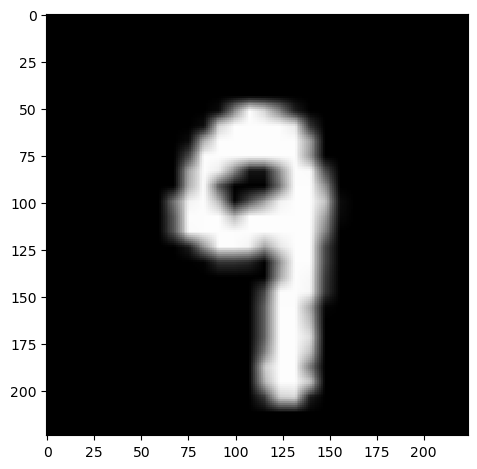

In [12]:
# Look at an image while testing the __getitem__ method

image1,label1 = train_data.__getitem__(1)
print(image1.shape,type(image1),label1.shape)
image1 = np.array(image1)
image1 = np.moveaxis(image1,0,2)
#image1 = np.squeeze(image1)
print(image1.shape)
print(label1.shape,label1)
io.imshow(image1)
plt.show()

In [13]:
# Dataloader to get batches

train_loader = DataLoader(dataset=train_data, batch_size=32,shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=10,shuffle=False)
#next(iter(train_loader))


In [14]:
for i , (x_batch,y_batch) in enumerate(test_loader):     
    break
# x = x_batch[0].view(-1,1,28,28)
# y = y_batch[0].view(-1,1)
x_batch.shape,y_batch.shape

(torch.Size([10, 3, 224, 224]), torch.Size([10, 1, 1]))

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        targets = targets.type(torch.LongTensor)
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(data.float())
        
        targets = targets.squeeze()
        loss = criterion(outputs, targets)
        
        # Backward pass and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data.float())
        _, predicted = torch.max(outputs.data, 1)  # Get class label from model's output
        total += targets.size(0)
        correct += (predicted == targets.squeeze()).sum().item()
        

print(f"Accuracy: {100 * correct / total}%")

Epoch 1/1, Loss: 2.086160861836106e-07
Accuracy: 99.0%
